In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
import umap
from yellowbrick.cluster import SilhouetteVisualizer 
from sklearn.manifold import TSNE
import seaborn as sns

c:\Users\tere1\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
folder_path = r"C:\Users\tere1\OneDrive\Escritorio\TFM\datos_img"
# Cargar las características normalizadas por Z-score
df_fourier_z = pd.read_csv(os.path.join(folder_path, "features_fourier_all_zscore.csv"))
# Cargar las características normalizadas por Min-Max
df_fourier_mm = pd.read_csv(os.path.join(folder_path, "features_fourier_all_minmax.csv"))

In [3]:
df_fourier_z

,mean_magnitude,std_magnitude,low_freq_magnitude,high_freq_magnitude,filename,label
0,-0.675069,-0.789859,-0.897021,-1.099034,callo_1.png,smaller
1,-0.332674,0.421457,-0.087640,0.128736,callo_10.png,smaller
2,-0.726203,-1.157138,-0.882415,-0.876548,callo_100.png,smaller
3,-0.624806,-0.816866,-0.490506,-0.490618,callo_101.png,smaller
4,-1.317448,-1.644363,-1.428906,-1.326237,callo_102.png,smaller
...,...,...,...,...,...,...
532,0.749086,0.945783,0.887860,0.885922,callo_95.png,higher
533,0.989613,0.780056,1.338128,1.304986,callo_96.png,higher
534,0.873905,0.820400,0.651903,0.660034,callo_97.png,higher
535,0.896289,1.520130,0.721742,1.004862,callo_98.png,higher


In [4]:
#Se eliminan los datos no numéricos: 'label' y 'filename'
df_fourier_z_cl= df_fourier_z.drop(columns=['filename', 'label'])

Se realiza clustering con k-means. Para averiguar cual va a ser el mejor valor de k o clusters se aplica el método
del "codo". También se simularán con diferentes números de clusteres la silueta.

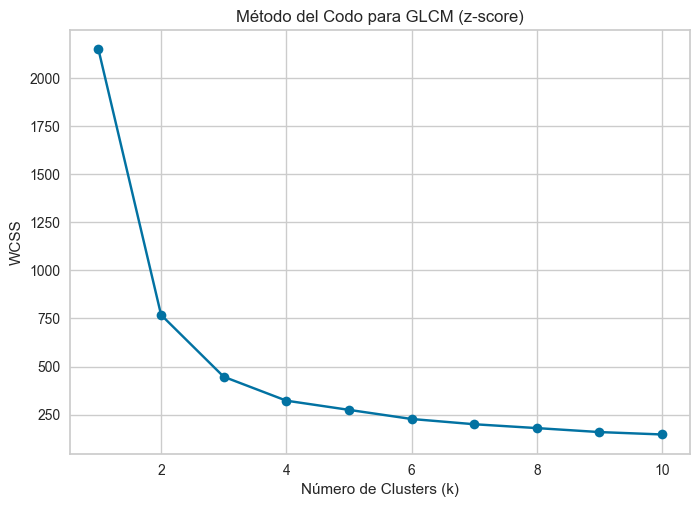

In [5]:
# Método del codo
WCSS = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=1000, random_state=42)
    kmeans.fit(df_fourier_z_cl)
    WCSS.append(kmeans.inertia_)

# Graficar el codo
plt.plot(range(1, 11), WCSS, marker='o')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('WCSS')
plt.title('Método del Codo para GLCM (z-score)')
plt.grid(True)
plt.show()

c:\Users\tere1\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(
c:\Users\tere1\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(
c:\Users\tere1\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(
c:\Users\tere1\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


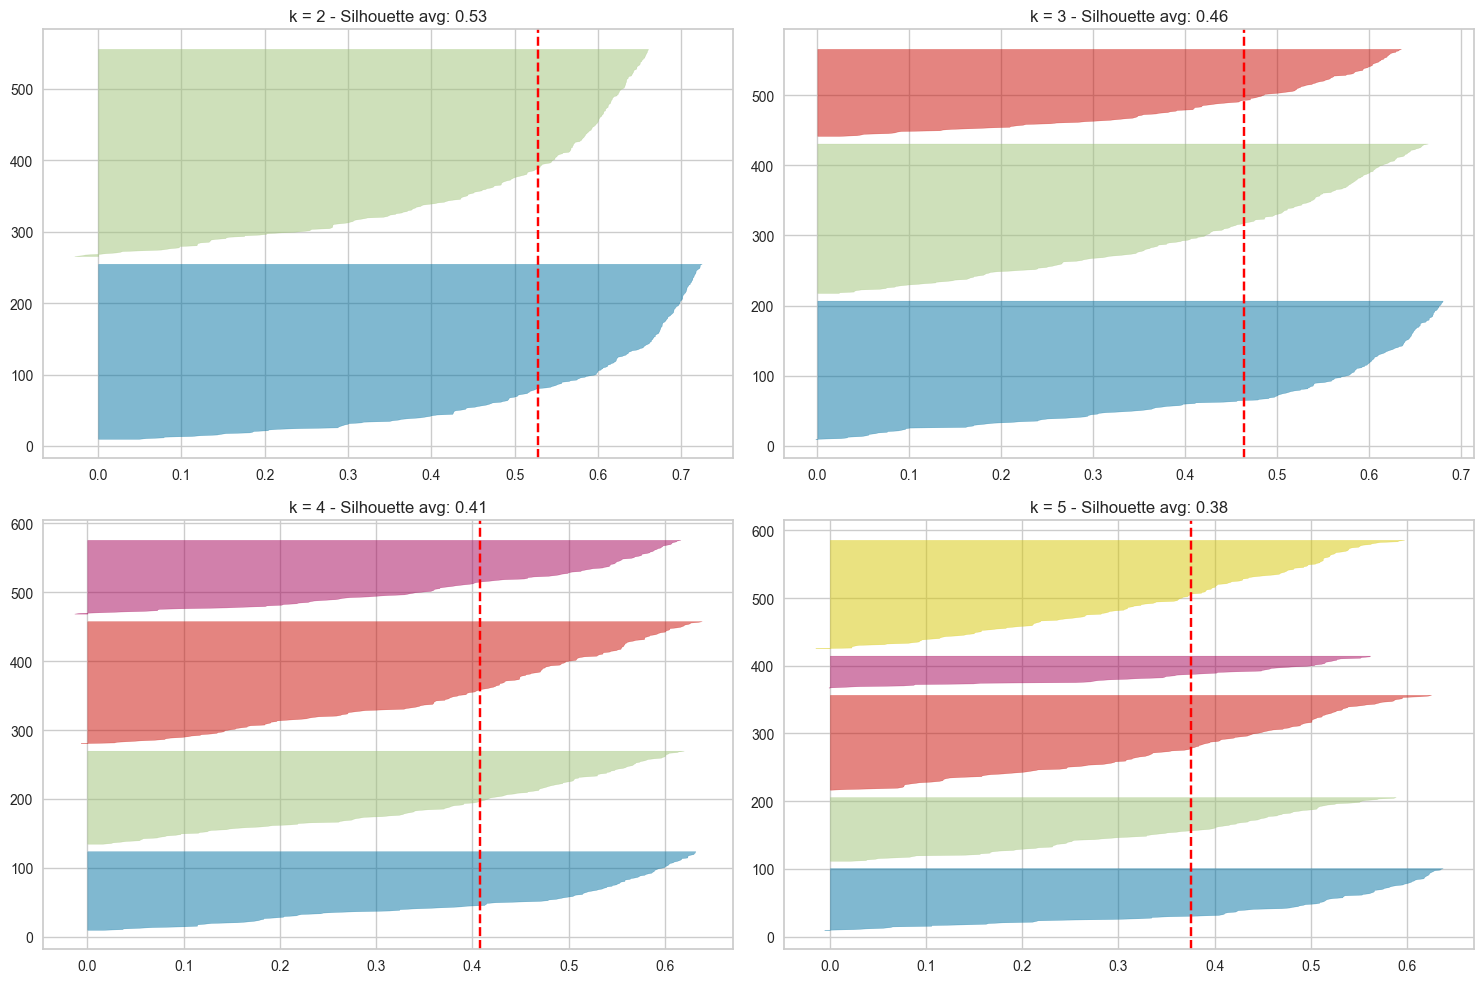

In [6]:
# Crear figura de 2x2 subplots
fig, ax = plt.subplots(2, 2, figsize=(15, 10))

# Probar con k = 2, 3, 4, 5
for i, k in enumerate([2, 3, 4, 5]):
    # Crear el modelo de clustering
    km = KMeans(n_clusters=k, init='k-means++', n_init=10, max_iter=300, random_state=42)
    
    # Ajustar el modelo a los datos
    km.fit(df_fourier_z_cl)

    # Calcular el promedio del coeficiente de silueta
    silhouette_avg = silhouette_score(df_fourier_z_cl, km.labels_)
    
    # Subplot correspondiente
    row = i // 2
    col = i % 2
    ax_i = ax[row][col]

    # Crear visualizador Silhouette con el eje adecuado
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax_i)
    visualizer.fit(df_fourier_z_cl)

    # Personalizar el título con el valor de la silueta
    ax_i.set_title(f'k = {k} - Silhouette avg: {silhouette_avg:.2f}')

plt.tight_layout()
plt.show()

Teniendo en cuenta estos dos criterios se selecciona como mejor opción 2 clusters.

In [7]:
#Modelo k-means
cluster_fourier_z= KMeans(init='k-means++',n_clusters=2,random_state=42)
cluster_fourier_z.fit(df_fourier_z_cl)   

KMeans(n_clusters=2, random_state=42)

In [8]:
#Se añaden las etiquetas y vemos en una tabla de contigencia cuantos smaller o higher hay en cada cluster
df_fourier_z['Cluster'] = cluster_fourier_z.labels_
pd.crosstab(df_fourier_z['Cluster'], df_fourier_z['label'])

label,higher,smaller
Cluster,,
0,33,213
1,235,56


In [9]:
silhouette_avg_fourier_z = silhouette_score(df_fourier_z_cl, cluster_fourier_z.labels_)
print(f'Índice de silueta promedio: {silhouette_avg_fourier_z}')

Índice de silueta promedio: 0.5274044419590056


Visualización con Tsne y UMAP.

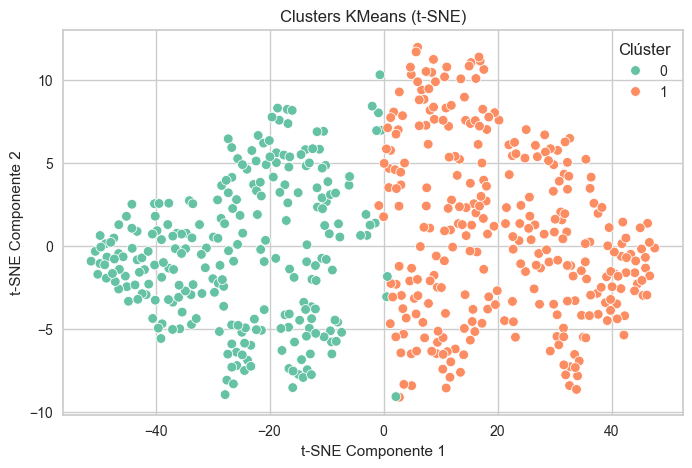

In [10]:
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(df_fourier_z_cl)

# Visualización
plt.figure(figsize=(8, 5))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=df_fourier_z['Cluster'], palette='Set2')
plt.title('Clusters KMeans (t-SNE)')
plt.xlabel('t-SNE Componente 1')
plt.ylabel('t-SNE Componente 2')
plt.legend(title='Clúster')
plt.grid(True)
plt.show()

c:\Users\tere1\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\tere1\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


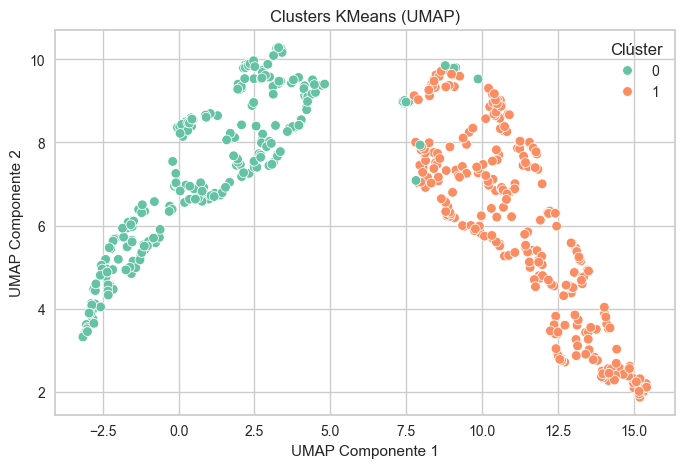

In [11]:
umap_model = umap.UMAP(n_components=2, random_state=42)
X_umap = umap_model.fit_transform(df_fourier_z_cl)

# Visualización
plt.figure(figsize=(8, 5))
sns.scatterplot(x=X_umap[:, 0], y=X_umap[:, 1], hue=df_fourier_z['Cluster'], palette='Set2')
plt.title('Clusters KMeans (UMAP)')
plt.xlabel('UMAP Componente 1')
plt.ylabel('UMAP Componente 2')
plt.legend(title='Clúster')
plt.grid(True)
plt.show()

In [12]:
# Guardar resultados en DataFrame
df_resultado_z = pd.DataFrame({
    'filename': df_fourier_z['filename'],
    'label': df_fourier_z['label'],
    'cluster': df_fourier_z['Cluster']
})

# Guardar en archivo CSV 
#df_resultado_z.to_csv(os.path.join(folder_path, 'resultado_kmeans_fourier_z.csv'), index=False)
df_resultado_z

,filename,label,cluster
0,callo_1.png,smaller,0
1,callo_10.png,smaller,1
2,callo_100.png,smaller,0
3,callo_101.png,smaller,0
4,callo_102.png,smaller,0
...,...,...,...
532,callo_95.png,higher,1
533,callo_96.png,higher,1
534,callo_97.png,higher,1
535,callo_98.png,higher,1


El 87.8% de las imágenes HIGHER están en el cluster1, y las SMALLER (79.18%) están en el cluster 0. Silueta: 0.527>0.5, y viendo las gráficas los clusteres están bien separados pero puede que la silueta no sea mayor porque dentro de los clusteres los puntos no están muy próximos.

Ahora se realiza lo mismo pero con la normalización min-max

In [13]:
df_fourier_mm

,mean_magnitude,std_magnitude,low_freq_magnitude,high_freq_magnitude,filename,label
0,0.321215,0.291837,0.274240,0.234906,callo_1.png,smaller
1,0.382919,0.518457,0.426258,0.434512,callo_10.png,smaller
2,0.312000,0.223125,0.276983,0.271077,callo_100.png,smaller
3,0.330273,0.286785,0.350592,0.333820,callo_101.png,smaller
4,0.205450,0.131972,0.174341,0.197968,callo_102.png,smaller
...,...,...,...,...,...,...
532,0.577865,0.616550,0.609478,0.557612,callo_95.png,higher
533,0.621211,0.585545,0.694047,0.625742,callo_96.png,higher
534,0.600359,0.593093,0.565160,0.520888,callo_97.png,higher
535,0.604393,0.724002,0.578277,0.576949,callo_98.png,higher


In [14]:
#Se eliminan los datos no numéricos: 'label' y 'filename'
df_fourier_mm_cl= df_fourier_mm.drop(columns=['filename', 'label'])

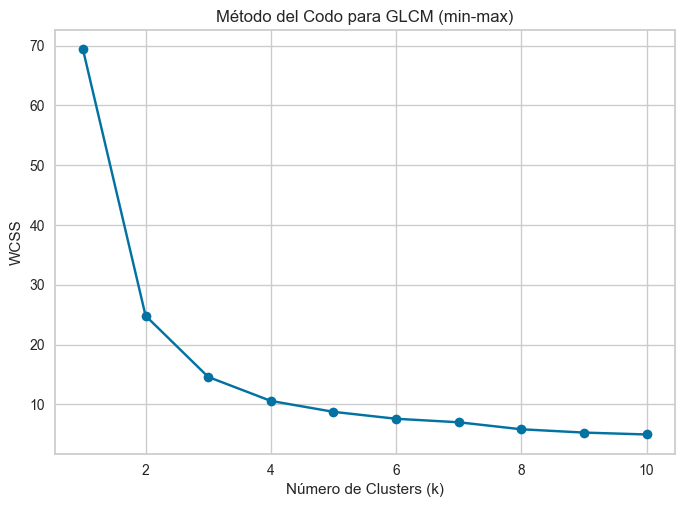

In [15]:
# Método del codo
WCSS = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=1000, random_state=42)
    kmeans.fit(df_fourier_mm_cl)
    WCSS.append(kmeans.inertia_)

# Graficar el codo
plt.plot(range(1, 11), WCSS, marker='o')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('WCSS')
plt.title('Método del Codo para GLCM (min-max)')
plt.grid(True)
plt.show()

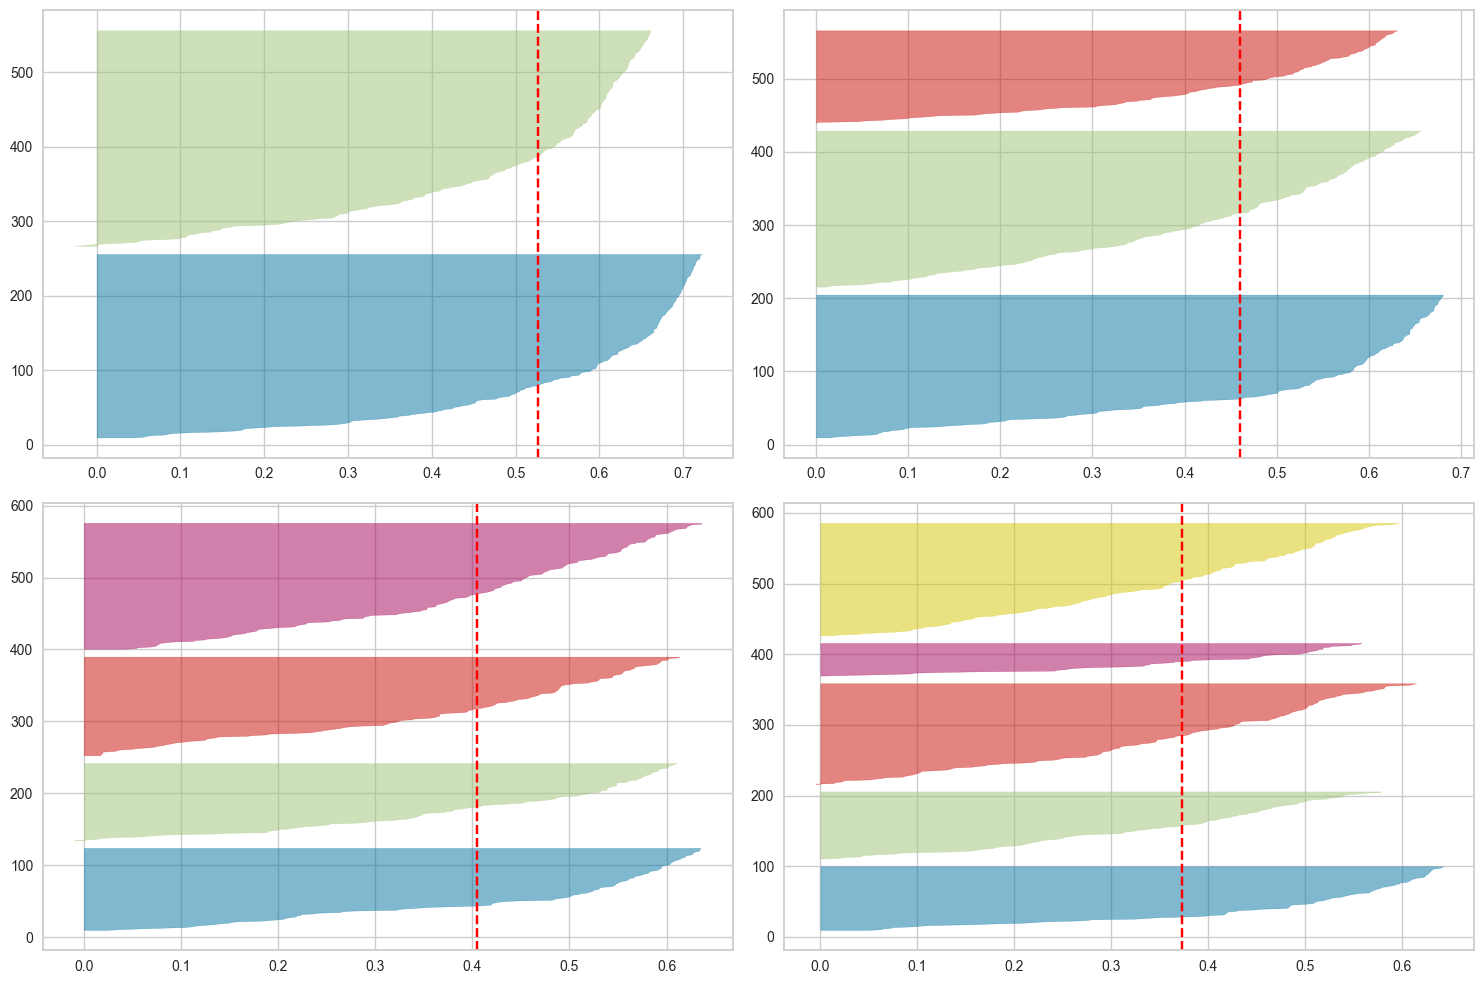

In [ ]:
# Creamos la figura con 2x2 subplots
fig, ax = plt.subplots(2, 2, figsize=(15, 10))

# Probamos con k = 2, 3, 4, 5
for i, k in enumerate([2, 3, 4, 5]):
    km = KMeans(n_clusters=k, init='k-means++', n_init=10, max_iter=300, random_state=42)
    
    # Posición del subplot
    row = i // 2
    col = i % 2
    
    # Creamos el visualizador y ajustamos los datos
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[row][col])
    visualizer.fit(df_fourier_mm_cl)  

plt.tight_layout()
plt.show()

In [17]:
#Modelo k-means
cluster_fourier_mm= KMeans(init='k-means++',n_clusters=2,random_state=42)
cluster_fourier_mm.fit(df_fourier_mm_cl) 

KMeans(n_clusters=2, random_state=42)

In [18]:
#Se añaden las etiquetas y vemos en una tabla de contigencia cuantos smaller o higher hay en cada cluster
df_fourier_mm['Cluster'] = cluster_fourier_mm.labels_
pd.crosstab(df_fourier_mm['Cluster'], df_fourier_mm['label'])

label,higher,smaller
Cluster,,
0,33,214
1,235,55


In [19]:
silhouette_avg_fourier_mm = silhouette_score(df_fourier_mm_cl, cluster_fourier_mm.labels_)
print(f'Índice de silueta promedio: {silhouette_avg_fourier_mm}')

Índice de silueta promedio: 0.5268876144353454


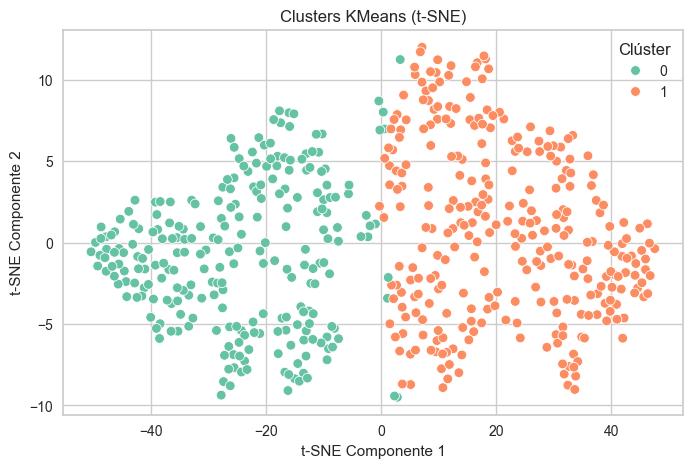

In [20]:
tsne_mm = TSNE(n_components=2, random_state=42)
X_tsne_mm = tsne_mm.fit_transform(df_fourier_mm_cl)

# Visualización
plt.figure(figsize=(8, 5))
sns.scatterplot(x=X_tsne_mm[:, 0], y=X_tsne_mm[:, 1], hue=df_fourier_mm['Cluster'], palette='Set2')
plt.title('Clusters KMeans (t-SNE)')
plt.xlabel('t-SNE Componente 1')
plt.ylabel('t-SNE Componente 2')
plt.legend(title='Clúster')
plt.grid(True)
plt.show()


c:\Users\tere1\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\tere1\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


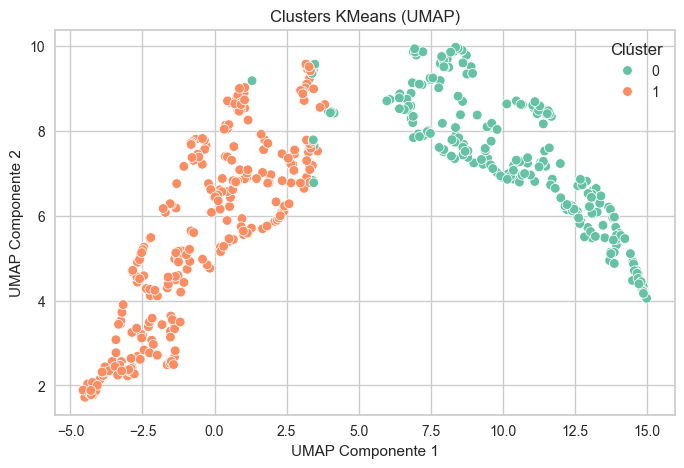

In [21]:
umap_model = umap.UMAP(n_components=2, random_state=42)
X_umap = umap_model.fit_transform(df_fourier_mm_cl)

# Visualización
plt.figure(figsize=(8, 5))
sns.scatterplot(x=X_umap[:, 0], y=X_umap[:, 1], hue=df_fourier_mm['Cluster'], palette='Set2')
plt.title('Clusters KMeans (UMAP)')
plt.xlabel('UMAP Componente 1')
plt.ylabel('UMAP Componente 2')
plt.legend(title='Clúster')
plt.grid(True)
plt.show()

Aunque no creo que sea necesario porque se pueden ver los clusters bien separados voy a probar a reducir la dimensionalidad con umap y aplicar de nuevo kmeans sobre esos resultados.

c:\Users\tere1\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\tere1\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


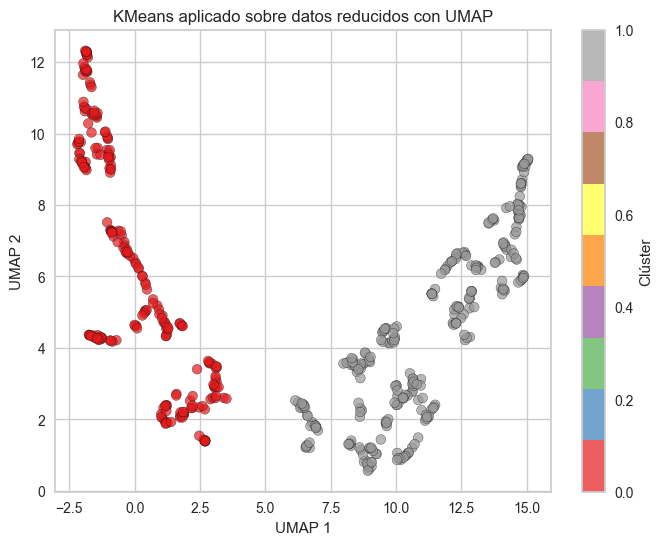

Índice de silueta (UMAP + KMeans): 0.619


In [22]:

# 1. Reducción de dimensionalidad con UMAP
umap_model = umap.UMAP(n_neighbors=9, n_components=2, min_dist=0.01, random_state=42)
X_umap = umap_model.fit_transform(df_fourier_z_cl)

# 2. Aplicar KMeans sobre el espacio reducido
kmeans = KMeans(n_clusters=2, init='k-means++', random_state=42)
clusters = kmeans.fit_predict(X_umap)

# 3. Añadir los clústeres al dataframe original
df_fourier_z['Cluster_UMAP'] = clusters

# 4. Visualizar los resultados
plt.figure(figsize=(8, 6))
plt.scatter(
    X_umap[:, 0], X_umap[:, 1],
    c=clusters, cmap='Set1', edgecolor='k', alpha=0.7
)
plt.title('KMeans aplicado sobre datos reducidos con UMAP')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.colorbar(label='Clúster')
plt.grid(True)
plt.show()

# 5. Índice de silueta
silhouette = silhouette_score(X_umap, clusters)
print(f"Índice de silueta (UMAP + KMeans): {silhouette:.3f}")


In [23]:
pd.crosstab(df_fourier_z['label'], df_fourier_z['Cluster_UMAP'])


Cluster_UMAP,0,1
label,,
higher,27,241
smaller,206,63


ocurre lo mismo que antes. Los clusteres están bien equilibrados y cada uno parece que reúne a cada conjunto de imágenes pero los puntos que forman los clusteres están distantes.

Al reducir la dimensionalidad los puntos estánmucho más juntos.

umap con mimax

c:\Users\tere1\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\tere1\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


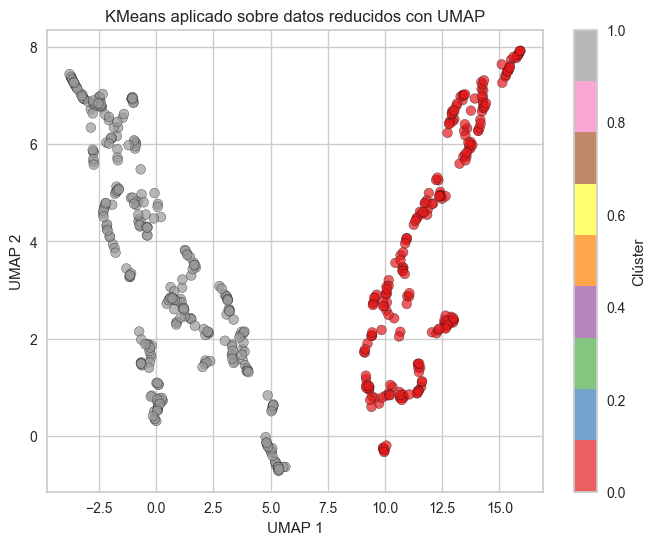

Índice de silueta (UMAP + KMeans): 0.655


In [24]:
# 1. Reducción de dimensionalidad con UMAP
umap_model_mm = umap.UMAP(n_neighbors=10, n_components=2, min_dist=0.01, random_state=42)
X_umap_mm = umap_model_mm.fit_transform(df_fourier_mm_cl)

# 2. Aplicar KMeans sobre el espacio reducido
kmeans_mm = KMeans(n_clusters=2, init='k-means++', random_state=42)
clusters_mm = kmeans_mm.fit_predict(X_umap_mm)

# 3. Añadir los clústeres al dataframe original
df_fourier_mm['Cluster_UMAP'] = clusters_mm

# 4. Visualizar los resultados
plt.figure(figsize=(8, 6))
plt.scatter(
    X_umap_mm[:, 0], X_umap_mm[:, 1],
    c=clusters_mm, cmap='Set1', edgecolor='k', alpha=0.7
)
plt.title('KMeans aplicado sobre datos reducidos con UMAP')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.colorbar(label='Clúster')
plt.grid(True)
plt.show()

# 5. Índice de silueta
silhouette_mm = silhouette_score(X_umap_mm, clusters_mm)
print(f"Índice de silueta (UMAP + KMeans): {silhouette_mm:.3f}")


In [25]:
pd.crosstab(df_fourier_mm['label'], df_fourier_mm['Cluster_UMAP'])

Cluster_UMAP,0,1
label,,
higher,25,243
smaller,206,63
